 19%|█▉        | 194/1000 [00:00<00:00, 951.77it/s]

2.0165
0.0656
0.0291
0.0125
0.0055
0.0020


100%|██████████| 1000/1000 [00:00<00:00, 2073.04it/s]


0.0011
0.0003
0.0003
0.0002


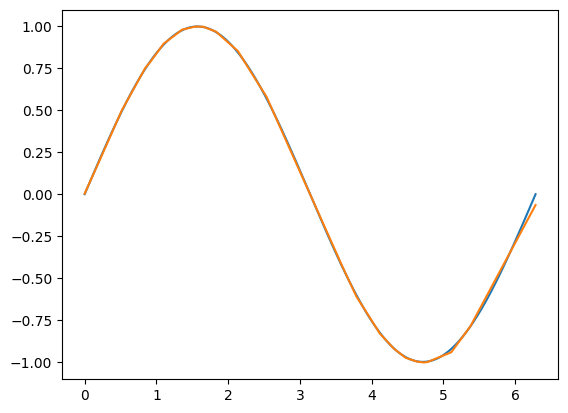

In [4]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

bs = 128
lr = 0.01
steps = 1000

model = nn.Sequential(
	nn.Linear(1, 100),
	nn.ReLU(),
	nn.Linear(100, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps, eta_min=lr * 0.01)

for i in trange(1000):
	x = torch.rand(bs) * 2 * 3.1415
	y = torch.sin(x)

	y_pred = model(x.unsqueeze(1))
	loss = loss_fn(y_pred.squeeze(), y)

	optimizer.zero_grad(True)
	loss.backward()
	optimizer.step()

	if i % 100 == 0:
		tqdm.write(f'{loss.item():.4f}')

x = torch.linspace(0, 2 * 3.1415, 10000)
y = torch.sin(x)
y_pred = model(x.unsqueeze(1)).detach()

plt.plot(x, y)
plt.plot(x, y_pred)
plt.show()

Step = 0 Cost = 1.0008220305122786
Step = 50 Cost = 0.0007713203532094914
Step = 100 Cost = 0.00017248396195919063
Step = 150 Cost = 7.38963639111891e-05
Step = 200 Cost = 4.0810887949216756e-05
Step = 250 Cost = 2.583238372634074e-05
Step = 300 Cost = 1.780734986246756e-05
Step = 350 Cost = 1.3014033334755201e-05
Step = 400 Cost = 9.924375322652338e-06
Step = 450 Cost = 7.817236721627177e-06
Step = 500 Cost = 6.31625809478156e-06
Step = 550 Cost = 5.2094301198222625e-06
Step = 600 Cost = 4.3699318949256335e-06
Step = 650 Cost = 3.718128669912878e-06
Step = 700 Cost = 3.20197143604839e-06
Step = 750 Cost = 2.7862769323936345e-06
Step = 800 Cost = 2.4465707059739726e-06
Step = 850 Cost = 2.165401291431658e-06
Step = 900 Cost = 1.9300537696598063e-06
Step = 950 Cost = 1.7310868831418145e-06


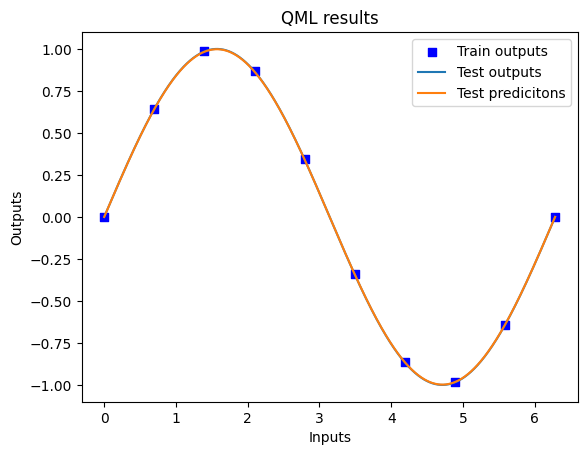

In [31]:
# In this program we will train a circuit to model a sine function

# We import the necessary libraries
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We create the training Data
X = np.linspace(0, 2*np.pi, 10) # 5 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
X.requires_grad = False
Y = np.sin(X) # The outputs for the input datapoints

# We create the test Data
# 5 test datapoints, shifted from the training data by 0.2
# Since we're not optimizing over the test data we
# don't need to specify requires_grad = False
X_test = np.linspace(0, 2*np.pi, 1000)
Y_test = np.sin(X_test) # The outputs for the test datapoints

# Step 1 - Create the device
# Here we use the 'default.qubit' simulator and 1 qubit (wires=1)
dev = qml.device('default.qubit', wires=1)

# Step 2 - Create the quantum circuit
@qml.qnode(dev)
def quantum_circuit(params, datapoint):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(params, X_list, Y_list):
    predictions = [quantum_circuit(params, x)  for x in X_list]
    return square_loss(Y_list, predictions)


# Steps 5.1 and 5.2  - We define the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.3)

# Step 5.3 We make an initial guess for the parameters
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Step 5.4 - We iterate over a number of defined steps (100)
for i in range (1000):
    # Over each step the parameters change to give a better cost
    params, _, _ = opt.step(cost, params, X, Y)
    if i%50 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i}, Cost = {cost(params, X, Y)}')

# Step 6 - Test and graph your results!
test_predictions =  [quantum_circuit(params, x)  for x in X_test]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, c='b', marker="s", label='Train outputs')
ax1.plot(X_test,Y_test, label='Test outputs')
ax1.plot(X_test,test_predictions, label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

Step = 0 Cost = 4.912499465469817
Step = 10 Cost = 0.017712616264713713
Step = 20 Cost = 0.0010549650559467637
Step = 30 Cost = 0.00033478390918249644
Step = 40 Cost = 0.00019081038150773464
Step = 50 Cost = 0.00012461609775915093
Step = 60 Cost = 8.781349557162982e-05
Step = 70 Cost = 6.522398226890529e-05
Step = 80 Cost = 5.0362401887345095e-05
Step = 90 Cost = 4.006386705383739e-05


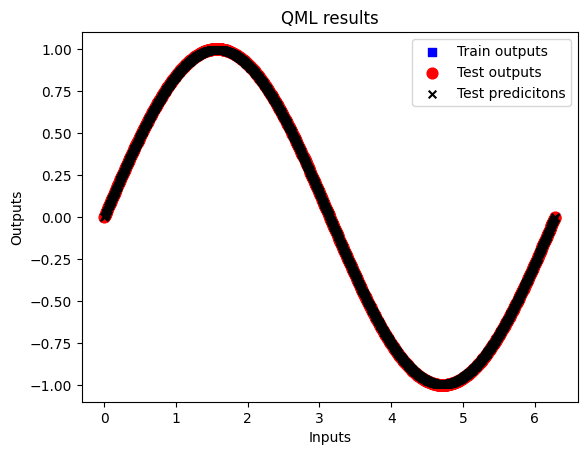

In [23]:
# In this program we will train a circuit to model a sine function

# We import the necessary libraries
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We create the training Data
X = np.linspace(0, 2*np.pi, 5) # 5 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
X.requires_grad = False
Y = np.sin(X) # The outputs for the input datapoints

# We create the test Data
# 5 test datapoints, shifted from the training data by 0.2
# Since we're not optimizing over the test data we
# don't need to specify requires_grad = False
X_test = np.linspace(0, 2*np.pi, 1000)
Y_test = np.sin(X_test) # The outputs for the test datapoints

# Step 1 - Create the device
# Here we use the 'default.qubit' simulator and 1 qubit (wires=1)
dev = qml.device('default.qubit', wires=1)

# Step 2 - Create the quantum circuit
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

# Step 3 - Classical Pre/Postprocessing
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.
    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses
    #return np.mean((Y - qml.math.stack(predictions)) ** 2)

# Step 4 - Define your cost function, including any classical pre/postprocessing
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    predictions = [quantum_circuit(x, params)  for x in X]
    # We calculate the cost including any classical postprocessing
    cost = loss_func(predictions)
    return cost

# Steps 5.1 and 5.2  - We define the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.3)

# Step 5.3 We make an initial guess for the parameters
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Step 5.4 - We iterate over a number of defined steps (100)
for i in range (100):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {cost_fn(params)}')

# Step 6 - Test and graph your results!
test_predictions = []
for x_test in X_test:
    prediction = quantum_circuit(x_test,params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()